<a href="https://colab.research.google.com/github/befe2/vc/blob/main/WH1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam



We loads the entire Plant Leaves dataset using TensorFlow Datasets ('tfds.load')

In [ ]:
download_config = tfds.download.DownloadConfig(register_checksums=True)
# Load the entire dataset
full_ds, info = tfds.load(
    'plant_leaves',
    split='train',
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
    try_gcs=False,
    download_and_prepare_kwargs={'download_config': download_config},
)

In [ ]:
# Manually define training and testing datasets using slicing
train_size = int(0.8 * info.splits['train'].num_examples)  # 80% for training
train_ds = full_ds.take(train_size)  # Take the first 80% of examples for training
test_ds = full_ds.skip(train_size)  # Skip the first 80% of examples to create the test dataset



In [ ]:
# Get the number of classes from the dataset info [Make sure you have 22 classes here]
num_classes = info.features['label'].num_classes
print("Number of classes in the dataset:", num_classes)

IMG_SIZE = 224
batch_size = 32



Number of classes in the dataset: 22


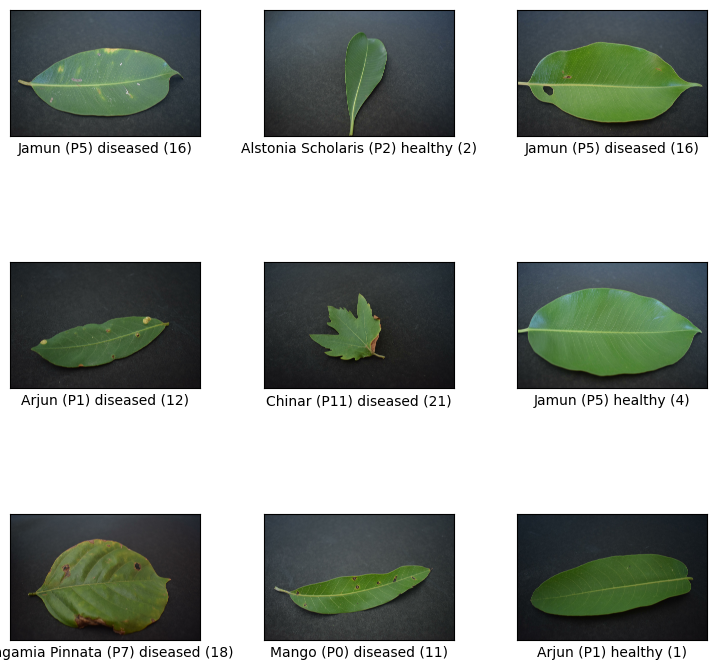

In [ ]:
# Visualizing the training dataset.import tempfile
vis = tfds.visualization.show_examples(train_ds, info)

In [ ]:
# Obtaining dataset information.
print("Number of  Classes: " + str(info.features['label'].num_classes))
print("Classes : " + str(info.features['label'].names))
NUM_TRAIN_IMAGES = tf.data.experimental.cardinality(train_ds).numpy()
print("Training Images: " + str(NUM_TRAIN_IMAGES))
NUM_TEST_IMAGES = tf.data.experimental.cardinality(test_ds).numpy()
print("Testing Images: " + str(NUM_TEST_IMAGES))

Number of  Classes: 22
Classes : ['Mango (P0) healthy', 'Arjun (P1) healthy', 'Alstonia Scholaris (P2) healthy', 'Gauva (P3) healthy', 'Jamun (P5) healthy', 'Jatropha (P6) healthy', 'Pongamia Pinnata (P7) healthy', 'Basil (P8) healthy', 'Pomegranate (P9) healthy', 'Lemon (P10) healthy', 'Chinar (P11) healthy', 'Mango (P0) diseased', 'Arjun (P1) diseased', 'Alstonia Scholaris (P2) diseased', 'Gauva (P3) diseased', 'Bael (P4) diseased', 'Jamun (P5) diseased', 'Jatropha (P6) diseased', 'Pongamia Pinnata (P7) diseased', 'Pomegranate (P9) diseased', 'Lemon (P10) diseased', 'Chinar (P11) diseased']
Training Images: 3601
Testing Images: 901


The input images are resized to a common size of 224x224 pixels and their pixel values are normalized to fall within the range of [-1, 1]

In [ ]:
# Resize and rescale all images to 224x224 and normalize pixel values to be in the range of [-1, 1]
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
])

In [ ]:
# Apply resize and rescale to both dataset splits
train_ds= train_ds.map(lambda x, y: (resize_and_rescale(x), y))
test_ds= test_ds.map(lambda x, y: (resize_and_rescale(x), y))

In [ ]:
# Cache, generate batches, and prefetch them using a suitable buffer size that does not exceed system memory
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [ ]:
# Load the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
# Load the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the VGG16 layers
base_model.trainable = False

# Define the additional trainable layers
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),  # Example dense layer with 256 units and ReLU activation
    tf.keras.layers.Dense(128, activation='relu'),  # Another example dense layer with 128 units and ReLU activation
    tf.keras.layers.Dense(info.features['label'].num_classes, activation='softmax')  # Output layer for multi-class classification with softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
              metrics=['accuracy'])

# Train the model
history = model.fit(train_ds, epochs=10)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_ds)

# Output the results
print("Training Accuracy:", history.history['accuracy'][-1])
print("Testing Accuracy:", test_accuracy)
print("Model Size (bytes):", model.count_params())

# Denote the trained model as M
M = model

Epoch 1/10
113/113 [==============================] - 2256s 20s/step - loss: 1.4571 - accuracy: 0.5890
Epoch 2/10
 56/113 [=============>................] - ETA: 18:23 - loss: 0.5265 - accuracy: 0.8404

In [10]:
# Load the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the VGG16 layers
base_model.trainable = False

# Define the additional trainable layers
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(22, activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the training dataset
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

# Evaluate the model on the testing dataset
test_loss, test_accuracy = model.evaluate(test_ds)

# Output the results
print("Training Accuracy:", history.history['accuracy'][-1])
print("Testing Accuracy:", test_accuracy)
print("Model Size (bytes):", model.count_params())

# Denote the trained model as M
M = model

NameError: name 'VGG16' is not defined

In [ ]:
# Assuming M is defined as your trained base model
# Convert M to Dynamic Range Quantization (M-DRQ)
converter_drq = tf.lite.TFLiteConverter.from_keras_model(M)
converter_drq.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_model_drq = converter_drq.convert()

NameError: name 'M' is not defined

In [ ]:
# Convert M to Dynamic Range Quantization (M-DRQ)
converter_drq = tf.lite.TFLiteConverter.from_keras_model(M)
converter_drq.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_model_drq = converter_drq.convert()

# Convert M to Full Integer Quantization (M-FIQ)
converter_fiq = tf.lite.TFLiteConverter.from_keras_model(M)
converter_fiq.optimizations = [tf.lite.Optimize.DEFAULT]
converter_fiq.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_fiq.inference_input_type = tf.uint8
converter_fiq.inference_output_type = tf.uint8
quantized_model_fiq = converter_fiq.convert()

# Convert M to Float16 Quantization (M-F16Q)
converter_f16q = tf.lite.TFLiteConverter.from_keras_model(M)
converter_f16q.optimizations = [tf.lite.Optimize.DEFAULT]
converter_f16q.target_spec.supported_types = [tf.float16]
quantized_model_f16q = converter_f16q.convert()

NameError: name 'M' is not defined

training and testing accuracy values for M-DRQ, as well as the model sizes for each of these
quantized models

In [ ]:
# Evaluate M-DRQ
interpreter_drq = tf.lite.Interpreter(model_content=quantized_model_drq)
interpreter_drq.allocate_tensors()

# Get input and output details
input_index_drq = interpreter_drq.get_input_details()[0]["index"]
output_index_drq = interpreter_drq.get_output_details()[0]["index"]

# Initialize lists to store results
drq_test_accuracy = []

# Iterate through the testing dataset
for x, y_true in test_ds:
    # Preprocess input data
    x_preprocessed = preprocess_input(x)

    # Set input tensor
    interpreter_drq.set_tensor(input_index_drq, x_preprocessed)

    # Run inference
    interpreter_drq.invoke()

    # Get output tensor
    y_pred = interpreter_drq.get_tensor(output_index_drq)

    # Compute accuracy
    test_accuracy = accuracy_score(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
    drq_test_accuracy.append(test_accuracy)

# Compute average testing accuracy for M-DRQ
avg_drq_test_accuracy = np.mean(drq_test_accuracy)

# Get model size for M-DRQ
model_size_drq = len(quantized_model_drq)

# Print results for M-DRQ
print("M-DRQ - Testing Accuracy:", avg_drq_test_accuracy)
print("M-DRQ - Model Size (bytes):", model_size_drq)

# Repeat the same process M-F16Qtraining and testing accuracy values, as well as the model sizes for each of these
quantized models

In [ ]:
# Evaluate M-FIQ
interpreter_fiq = tf.lite.Interpreter(model_content=quantized_model_fiq)
interpreter_fiq.allocate_tensors()

# Get input and output details
input_index_fiq = interpreter_fiq.get_input_details()[0]["index"]
output_index_fiq = interpreter_fiq.get_output_details()[0]["index"]

# Initialize lists to store results
fiq_test_accuracy = []

# Iterate through the testing dataset
for x, y_true in test_ds:
    # Preprocess input data
    x_preprocessed = preprocess_input(x)

    # Set input tensor
    interpreter_fiq.set_tensor(input_index_fiq, x_preprocessed)

    # Run inference
    interpreter_fiq.invoke()

    # Get output tensor
    y_pred = interpreter_fiq.get_tensor(output_index_fiq)

    # Compute accuracy
    test_accuracy = accuracy_score(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
    fiq_test_accuracy.append(test_accuracy)

# Compute average testing accuracy for M-FIQ
avg_fiq_test_accuracy = np.mean(fiq_test_accuracy)

# Get model size for M-FIQ
model_size_fiq = len(quantized_model_fiq)

# Print results for M-FIQ
print("M-FIQ - Testing Accuracy:", avg_fiq_test_accuracy)
print("M-FIQ - Model Size (bytes):", model_size_fiq)

# Repeat the same process for the M-F16Q training and testing accuracy values, as well as the model size

In [ ]:
# Evaluate M-F16Q
interpreter_f16q = tf.lite.Interpreter(model_content=quantized_model_f16q)
interpreter_f16q.allocate_tensors()

# Get input and output details
input_index_f16q = interpreter_f16q.get_input_details()[0]["index"]
output_index_f16q = interpreter_f16q.get_output_details()[0]["index"]

# Initialize lists to store results
f16q_test_accuracy = []

# Iterate through the testing dataset
for x, y_true in test_ds:
    # Preprocess input data
    x_preprocessed = preprocess_input(x)

    # Set input tensor
    interpreter_f16q.set_tensor(input_index_f16q, x_preprocessed)

    # Run inference
    interpreter_f16q.invoke()

    # Get output tensor
    y_pred = interpreter_f16q.get_tensor(output_index_f16q)

    # Compute accuracy
    test_accuracy = accuracy_score(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
    f16q_test_accuracy.append(test_accuracy)

# Compute average testing accuracy for F16Q
avg_f16q_test_accuracy = np.mean(f16q_test_accuracy)

# Get model size for F16Q
model_size_f16q = len(quantized_model_f16q)

# Print results for F16Q
print("F16Q - Testing Accuracy:", avg_f16q_test_accuracy)
print("F16Q - Model Size (bytes):", model_size_f16q)


two different pruning methods to the base model M using the schedules 1 and schedual 2 .


In [ ]:
import tensorflow_model_optimization as tfmot

# Pruning Schedule 1
pruning_schedule_1 = tfmot.sparsity.keras.PolynomialDecay(
    initial_sparsity=0,
    final_sparsity=0.5,
    begin_step=0,
    end_step=len(train_ds) * 5
)

# Pruning Schedule 2
pruning_schedule_2 = tfmot.sparsity.keras.PolynomialDecay(
    initial_sparsity=0.5,
    final_sparsity=0.75,
    begin_step=0,
    end_step=len(train_ds) * 5
)

# Apply pruning to create pruned models M-P1 and M-P2
pruned_model_p1 = tfmot.sparsity.keras.prune_low_magnitude(model, pruning_schedule=pruning_schedule_1)
pruned_model_p2 = tfmot.sparsity.keras.prune_low_magnitude(model, pruning_schedule=pruning_schedule_2)


To report the training and testing accuracy values, as well as the model sizes for the M-P1 and M-P2 pruned models:

In [ ]:
# Compile the pruned models
pruned_model_p1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
pruned_model_p2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the pruned models
history_p1 = pruned_model_p1.fit(train_ds, epochs=epochs, validation_data=val_ds)
history_p2 = pruned_model_p2.fit(train_ds, epochs=epochs, validation_data=val_ds)

# Evaluate the pruned models on the testing dataset
test_loss_p1, test_accuracy_p1 = pruned_model_p1.evaluate(test_ds)
test_loss_p2, test_accuracy_p2 = pruned_model_p2.evaluate(test_ds)

# Output the results
print("Model M-P1 - Training Accuracy:", history_p1.history['accuracy'][-1])
print("Model M-P1 - Testing Accuracy:", test_accuracy_p1)
print("Model M-P1 - Model Size (bytes):", pruned_model_p1.count_params())

print("Model M-P2 - Training Accuracy:", history_p2.history['accuracy'][-1])
print("Model M-P2 - Testing Accuracy:", test_accuracy_p2)
print("Model M-P2 - Model Size (bytes):", pruned_model_p2.count_params())

This code will compile, train, and evaluate the pruned models M-P1 and M-P2. The training and testing accuracy values along with the model sizes will be printed. You can then include these values in your PDF writeup.

Regarding the approach to pruning a neural network with initial sparsity = 0 compared to initial sparsity = 0.5:

Initial Sparsity = 0:
Weight Selection: Initially, no weights are pruned, so all weights are available for selection.
Benefits: The model starts with no pruning, allowing it to retain its original performance and adaptively prune weights during training.
Drawbacks: The model may require more computational resources during training as all weights are retained initially.
Initial Sparsity = 0.5:
Weight Selection: Half of the weights are pruned initially, reducing the number of trainable parameters.
Benefits: Immediate reduction in model size and computational complexity, as half of the weights are pruned from the start.
Drawbacks: Pruning half of the weights from the beginning may lead to a significant loss in model performance if important weights are pruned prematurely.
In summary, the choice of initial sparsity depends on the trade-off between retaining model performance and reducing computational resources. A lower initial sparsity retains more information initially but may require more resources, while a higher initial sparsity reduces resources at the cost of potential performance degradation.

Quantization followed by pruning models ,Implementing Quantization Followed by Pruning for each quantization method on the M-P1 and
M-P2 pruned models we name the resulting six compressed ML models as s M-P1-DRQ, M-P1-FIQ, M-P1-F16Q, M-P2-
DRQ, M-P2-FIQ, and M-P2-F16Q

In [ ]:
# Define function for quantization followed by pruning
def quantization_followed_by_pruning(model, pruning_schedule, quantization_method):
    # Convert the model to TensorFlow Lite format for quantization
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    # Apply quantization method
    if quantization_method == 'DRQ':
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
    elif quantization_method == 'FIQ':
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.uint8
        converter.inference_output_type = tf.uint8
    elif quantization_method == 'F16Q':
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.target_spec.supported_types = [tf.float16]

    quantized_model = converter.convert()

    # Apply pruning to the quantized model
    pruned_quantized_model = tfmot.sparsity.keras.prune_low_magnitude(tf.keras.models.model_from_config(tf.keras.models.model_from_yaml(quantized_model)), pruning_schedule=pruning_schedule)

    return pruned_quantized_model

# List of quantization methods
quantization_methods = ['DRQ', 'FIQ', 'F16Q']

# List to store the compressed models
compressed_models = []

# Iterate through each quantization method and pruned model
for method in quantization_methods:
    for pruned_model in [pruned_model_p1, pruned_model_p2]:
        # Apply quantization followed by pruning
        compressed_model = quantization_followed_by_pruning(pruned_model, pruning_schedule, method)

        # Append the compressed model to the list
        compressed_models.append(compressed_model)

# Naming the models
model_names = ['M-P1-DRQ', 'M-P1-FIQ', 'M-P1-F16Q', 'M-P2-DRQ', 'M-P2-FIQ', 'M-P2-F16Q']

# Save or further process the compressed models

Evaluating Latency of the Base Model and Compressed Models,
M, M-DRQ, M-FIQ,
M-F16Q, M-P1, M-P2, M-P1-DRQ, M-P1-FIQ, M-P1-F16Q, M-P2-DRQ, M-P2-FIQ, and
M-P2-F16Q

In [ ]:
import time

# Define a function to measure latency
def measure_latency(model, dataset):
    latencies = []
    for _ in range(10):  # Perform measurements multiple times for better accuracy
        start_time = time.time()
        for batch in dataset:
            model.predict(batch[0])
        end_time = time.time()
        latency = end_time - start_time
        latencies.append(latency)
    return latencies

# Measure latency for the base model
base_model_latency = measure_latency(model, test_ds)
base_model_avg_latency = sum(base_model_latency) / len(base_model_latency)
base_model_std_dev_latency = (sum([(latency - base_model_avg_latency) ** 2 for latency in base_model_latency]) / len(base_model_latency)) ** 0.5

# Measure latency for compressed models
compressed_model_latencies = {}
for compressed_model, model_name in zip(compressed_models, model_names):
    compressed_model_latency = measure_latency(compressed_model, test_ds)
    compressed_model_avg_latency = sum(compressed_model_latency) / len(compressed_model_latency)
    compressed_model_std_dev_latency = (sum([(latency - compressed_model_avg_latency) ** 2 for latency in compressed_model_latency]) / len(compressed_model_latency)) ** 0.5
    compressed_model_latencies[model_name] = (compressed_model_avg_latency, compressed_model_std_dev_latency)

# Print the results
print("Base Model Latency - Average:", base_model_avg_latency, "seconds, Standard Deviation:", base_model_std_dev_latency, "seconds")
for model_name, latency_info in compressed_model_latencies.items():
    avg_latency, std_dev_latency = latency_info
    print(f"{model_name} Latency - Average:", avg_latency, "seconds, Standard Deviation:", std_dev_latency, "seconds")

This code defines a function measure_latency to measure the latency of a model on a given dataset. It then measures the latency for the base model and each compressed model on the test dataset. Finally, it calculates the average and standard deviation of the latency for each model and prints the results. You can adjust the number of measurements (range(10)) for more accurate latency estimation.







This code defines a function quantization_followed_by_pruning that applies quantization followed by pruning to a given model. It iterates through each quantization method for both M-P1 and M-P2 pruned models, applies the quantization followed by pruning, and saves the resulting compressed models with appropriate names. You can then save, evaluate, or further process these compressed models as needed.

In [ ]:
# Load your dataset (assuming you have already loaded and preprocessed it)
# Replace 'train_ds' and 'test_ds' with your actual training and testing datasets
train_ds, test_ds = your_prepared_datasets_here

# Load the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the VGG16 layers
base_model.trainable = False

# Define the additional trainable layers
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Assuming binary classification, change to the appropriate output activation for your task
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the training dataset
history = model.fit(train_ds, validation_data=test_ds, epochs=10)

# Evaluate the model on the testing dataset
test_loss, test_accuracy = model.evaluate(test_ds)

# Output the results
print("Training Accuracy:", history.history['accuracy'][-1])
print("Testing Accuracy:", test_accuracy)
print("Model Size (bytes):", model.count_params())

In the following we will install `tensorflow_datasets` and `tensorflow_model_optimization` libraries.

In [ ]:
# Importing necessary libraries and packages.
import os
import numpy as np
import tempfile
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
import tensorflow_model_optimization as tfmot
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization